In [12]:
import os
import sys
import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob
import random
from typing import List, Tuple
import numpy as np
from datasets import Dataset, DatasetDict
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


sys.path.append(os.path.join(os.path.dirname(__file__), ".."))
sys.path.append("/home/knf792/PycharmProjects/pixel-2/")

from pixel.utils.inference import encode_images
from pixel import PIXELForSequenceClassification



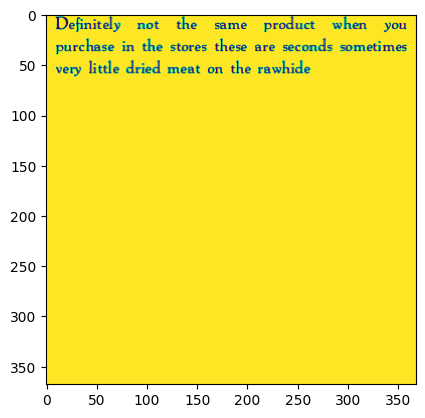

In [10]:
def load_images(root_path: str, n_images: int, test_ratio: float = 0.2):
    """
    A function to load images from a folder.
    """
    assert os.path.exists(root_path), "root_path does not exist"
    assert os.path.exists(os.path.join(root_path, "train")), "train folder does not exist"
    assert os.path.exists(os.path.join(root_path, "evaluation")), "evaluation folder does not exist"
    
    num_test_images = int(n_images * test_ratio)
    num_train_images = n_images - num_test_images
    
    train_paths = glob(os.path.join(root_path, "train", "*.png"))
    random.Random(42).shuffle(train_paths)
    train_paths = train_paths[:num_train_images]
    
    test_paths = glob(os.path.join(root_path, "evaluation", "*.png"))
    random.Random(42).shuffle(test_paths)
    test_paths = test_paths[:num_test_images]
    
    train_images = [(io.imread(path), path) for path in train_paths]
    test_images = [(io.imread(path), path) for path in test_paths]
    
    return train_images, test_images


def construct_dataset(model: PIXELForSequenceClassification, images: Tuple[np.ndarray, str]):
    """
    A function to construct a dataset from a list of images.
    """
    encodings = encode_images(model, [image[0] for image in images])
    dataset = Dataset.from_dict({"encoding": encodings, "path": [image[1] for image in images]})

    dataset["year"] = dataset["path"].map(lambda x: int(re.findall(r"\d+", x)[0]))
    dataset["decade"] = dataset["year"].map(lambda x: str(int(x / 10) * 10))
    dataset["century"] = dataset["year"].map(lambda x: str(int(x / 100) * 100))
    dataset["newspaper"] = dataset["path"].map(lambda x: x[:x.find("published")-1])
    
    # filter out samples where one of the labels is missing
    dataset = dataset.filter(lambda x: x["year"] != 0 and x["decade"] != 0 and x["century"] != 0)
    dataset = dataset.filter(lambda x: x["newspaper"] != "")
    return dataset
    
    
def get_datasets(model: PIXELForSequenceClassification, root_path: str, n_images: int, test_ratio: float = 0.2):
    """
    A function to load images from a folder and construct a dataset.
    """
    train_images, test_images = load_images(root_path, n_images, test_ratio)
    train_dataset = construct_dataset(model, train_images)
    test_dataset = construct_dataset(model, test_images)
    
    dataset = DatasetDict({"train": train_dataset, "test": test_dataset})
    return dataset


def train_linear_model(dataset, target: str = "century"):
    model = LogisticRegression()
    model.fit(dataset["train"][target], dataset["train"][target])
    return model


def evaluate_model(model, dataset, target: str = "century"):
    preds = model.predict(dataset["test"][target])
    print(classification_report(dataset["test"][target], preds))
    return preds

In [23]:
re.findall("\d+", "d_123esrs")

['123']